# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 14: Avoided Crossing Part 2
#### Example: Spin-Lock Induced Crossing (SLIC) - 2 spin half system
In previous tutorial we had plotted avoided crossing for two spin half system. In this tutorial we look into population "oscillation" between singlet and triplet states, when B1 amplitude (Spin Lock) equals J coupling (the SLIC condition). 

Reference: PhD Thesis, Stephen J. DeVience, Harward University, 2014.

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 4.7

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [0,2.8] # Offset frequency in Hz
deltaV = Offset[1] - Offset[0] # Frequency difference between Spin 1 and 2
"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-200.11400882 -200.11401162]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
off = -2*np.pi*deltaV/2 
OmegaRF = [-System.gammaH1*B0 + off ,-System.gammaH1*B0 + off] # RF iradiation in the middle of spin frequencies
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
"""
Define J couplings between individual spins
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 17.4
Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## B1 Hamiltonian (Spin Lock)

In [10]:
Omega1 = [Jlist[0][1],Jlist[0][1]] # SLIC condition: B1 amplitude equals J coupling between two spins
Omega1Phase = [0,0]
Hrf = System.Zeeman_B1(Sx,Sy,Omega1,Omega1Phase)

## Total Hamiltonian

In [11]:
Hslic = Hzr + Hj + Hrf # Hamiltonina duirng Spin Lock

## We will work with 4 Spin-Lock Eigenstates

1. Spin-Lock Eigenstates (when B1 amplitude of RF >> Chemical shift difference)
$$
|\phi_{+}> = \frac{1}{2}(|\alpha \alpha> + |\alpha \beta> + |\beta \alpha> + |\beta \beta>) = \frac{1}{\sqrt{2}}|T_{0}> + \frac{1}{2} (|T_{-}> + |T_{+}>)
$$
$$
|\phi_{0}> = \frac{1}{\sqrt{2}}(|\alpha \alpha> - |\beta \beta>) = \frac{1}{\sqrt{2}} (|T_{-}> - |T_{+}>)
$$
$$
|\phi_{S}> = \frac{1}{\sqrt{2}}(|\alpha \beta> - |\beta \alpha> ) = |S_{0}>
$$
$$
|\phi_{-}> = \frac{1}{2}(-|\alpha \alpha> + |\alpha \beta> + |\beta \alpha> - |\beta \beta>) = \frac{1}{\sqrt{2}}|T_{0}> - \frac{1}{2} (|T_{-}> + |T_{+}>)
$$

2. Zeeman Eigenstates
$$
|\alpha \alpha>, |\alpha \beta>, |\beta \alpha>, |\beta \beta>
$$

3. Singlet-Triplet States
$$
|T_{+}>, |T_{0}>, |T_{0}>, |S_{0}>
$$

In [12]:
"""
Zeeman eigen states
""";
B_Z = System.ZBasis_H(Hz)
Matrix(B_Z[0])

<IPython.core.display.Latex object>

Matrix([
[1.0],
[  0],
[  0],
[  0]])

In [13]:
"""
Lets make Spin-Lock Eigenstates from Zeeman eigen states
""";
Phi_p = 0.5 * (B_Z[0] + B_Z[1] + B_Z[2] + B_Z[3]) # linear combination of triplet states 
Phi_0 = (1/sqrt(2)) * (B_Z[0] - B_Z[3]) # linear combination of triplet states 
Phi_S = (1/sqrt(2)) * (B_Z[1] - B_Z[2]) # Singlet State
Phi_m = 0.5 * (B_Z[1] + B_Z[2] - B_Z[0] - B_Z[3]) # linear combination of triplet states 
Matrix(Phi_p)

Matrix([
[0.5],
[0.5],
[0.5],
[0.5]])

In [14]:
"""
Let make a basis transformation operator, U
Inorder to transform all operators from Zeeman basis to Spin-Lock Eigenstates
""";
U = np.zeros((System.Vdim,System.Vdim))
U[:,0] = Phi_m.T 
U[:,1] = Phi_0.T 
U[:,2] = Phi_p.T 
U[:,3] = Phi_S.T 
Matrix(U)

Matrix([
[-0.5,  0.707106781186548, 0.5,                  0],
[ 0.5,                  0, 0.5,  0.707106781186548],
[ 0.5,                  0, 0.5, -0.707106781186548],
[-0.5, -0.707106781186548, 0.5,                  0]])

In [15]:
"""
Lets make the population operators from Spin-Lock Eigenstates
pop_P population of Phi_p # linear combination of triplet states 
pop_0 population of Phi_0 # linear combination of triplet states 
pop_S population of Phi_S # Singlet states
pop_M population of Phi_m # linear combination of triplet states 
""";
pop_P = Phi_p @ Phi_p.T
pop_0 = Phi_0 @ Phi_0.T
pop_S = Phi_S @ Phi_S.T
pop_M = Phi_m @ Phi_m.T

In [16]:
Spin_Lock_Basis = True # If True, all operators will be converted to Spin Lock Basis else Zeeman Basis
if Spin_Lock_Basis:
    """
    Convert the operators into Spin-Lock basis
    """
    pop_P = np.linalg.inv(U) @ pop_P @ U
    pop_0 = np.linalg.inv(U) @ pop_0 @ U
    pop_S = np.linalg.inv(U) @ pop_S @ U
    pop_M = np.linalg.inv(U) @ pop_M @ U
    Hslic = np.linalg.inv(U) @ Hslic @ U  # Changing the basis of Hamiltonian to Spin-Lock basis

In [17]:
Matrix(pop_M)

Matrix([
[1.0, 0, 0, 0],
[  0, 0, 0, 0],
[  0, 0, 0, 0],
[  0, 0, 0, 0]])

In [18]:
Matrix(pop_0)

Matrix([
[0,   0, 0, 0],
[0, 1.0, 0, 0],
[0,   0, 0, 0],
[0,   0, 0, 0]])

In [19]:
Matrix(pop_P)

Matrix([
[0, 0,   0, 0],
[0, 0,   0, 0],
[0, 0, 1.0, 0],
[0, 0,   0, 0]])

In [20]:
Matrix(pop_S) # Singlet

Matrix([
[0, 0, 0,   0],
[0, 0, 0,   0],
[0, 0, 0,   0],
[0, 0, 0, 1.0]])

## Pulse

In [21]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,np.sum(Sy,axis=0)) 
if Spin_Lock_Basis:
    rho = np.linalg.inv(U) @  rho @ U # Changing the basis of density matrix to Spin-Lock basis

## Relaxation Constant

In [22]:
R1 = 1.0
R2 = 2.0
System.Relaxation_Constants(R1,R2)

Rprocess = "No Relaxation"

## Evolution of Density Matrix under first Spin Lock

In [23]:
dt = 1.0e-4
Spin_Lock_Time = 1
Npoints1 = int(Spin_Lock_Time/dt)
print("Number of points in the simulation", Npoints1)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t1, rho_t1 = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hslic,dt,Npoints1,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 10000
Total time = 0.08955025672912598 seconds 


## Expetation Value - Population

In [24]:
start_time = time.time()
t, population_P = System.Expectation_H(rho_t1,pop_P,dt,Npoints1)
t, population_0 = System.Expectation_H(rho_t1,pop_0,dt,Npoints1)
t, population_M = System.Expectation_H(rho_t1,pop_M,dt,Npoints1)
t, population_S = System.Expectation_H(rho_t1,pop_S,dt,Npoints1)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 115.93421840667725 seconds 


## Plotting the Population

<IPython.core.display.Javascript object>


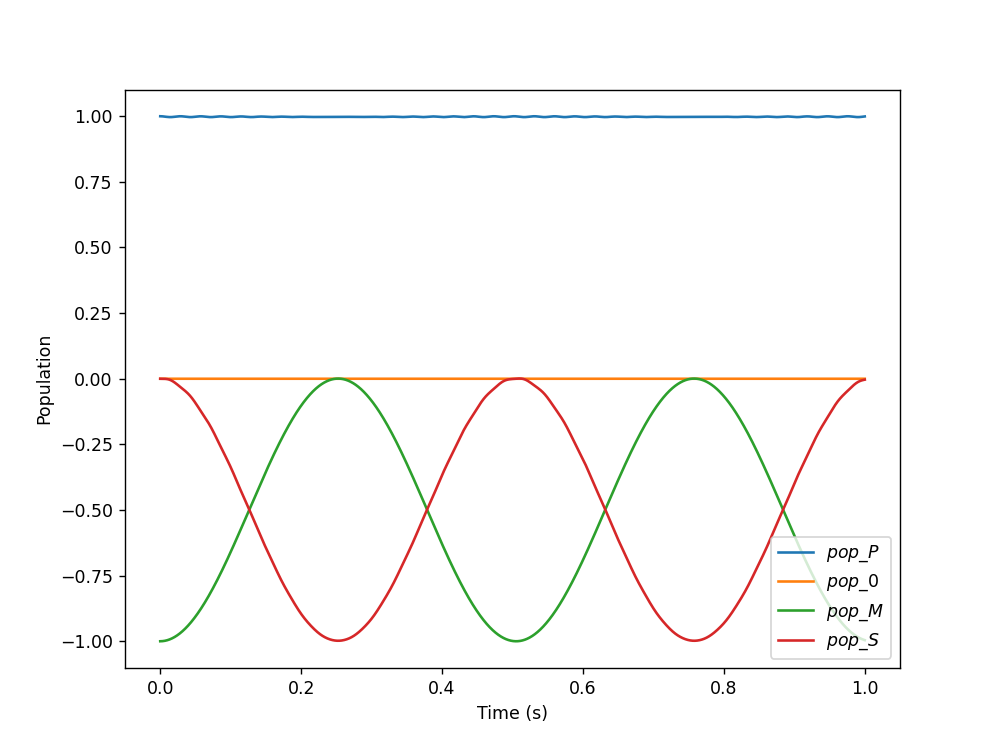

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [25]:
plt.figure(1)
plt.plot(t,population_P,"-",label=r"$pop\_P$")
plt.plot(t,population_0,"-",label=r"$pop\_0$")
plt.plot(t,population_M,"-",label=r"$pop\_M$")
plt.plot(t,population_S,"-",label=r"$pop\_S$")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()

## Conclusion:
So we can see the population between $pop\_M$ and $pop\_S$ oscillates. So if we apply spin lock for time, $t_{SLIC,max} = \frac{0.707}{\Delta \nu}$ ( in this case is it 0.2525 seconds), we can populate the singlet state. $\Delta \nu$ is the chemical shift difference.

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com